<a href="https://colab.research.google.com/github/realmistic/PythonInvest-basic-fin-analysis/blob/master/PythonInvest_com_4_Practical_Portfolio_Optimisation_(PyPortfolioOpt).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Practical Portfolio Optimisation**
* **What?** Identify an optimal split for a known set of stocks and a given investment size.
* **Why?** Smart portfolio management will add a lot to the risk management of your trades: it can reduce the volatility of a portfolio, increase returns per unit of risk, and reduce the bad cases losses
* **How?** Use the library PyPortfolioOpt 
  * User guide: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html
  * Detailed Colab example (Mean-Variance-Optimisation): https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb
* **Plan**
  0. Prep work : imports, getting financial data, and pivot table of daily prices
  1. Correlation matrix
  2. PyPortfolioOpt : min volatility, max Sharpe, and min cVAR portfolios  
  3. PyPortfolioOpt : Efficient Frontier
  4. PyPortfolioOpt : Discrete Allocation

* **Detailed Manual Optimisation for a short-term (3 days) trading** <br>
https://pythoninvest.com/long-read/practical-portfolio-optimisation

# 0. Prep work : imports, getting financial data, and pivot table of daily prices
Standard procedures for downloading the data with yfinance

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=7de673e0860cec4ad64202bdda822114ff5ce7f8b98ad17832aff0d803a8aab2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
INVESTMENT = 2000 

# PTR = PetroChina Company Limited ADR
# BUD = Anheuser Busch Inbev SA (AB InBev)
# XOM = Exxon Mobil Corporation
# BA = Boeing Co
# CHTR = Charter Communications Inc
# SHOP = Shopify Inc
# NVDA = NVIDIA Corporation
# NKE = Nike Inc

TICKERS =['PTR','BUD', 'XOM', 'BA','CHTR', 'SHOP', 'NVDA', 'NKE']

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


In [ ]:
stocks_prices = pd.DataFrame({'A' : []})
stocks_info = pd.DataFrame({'A' : []})

for i,ticker in enumerate(TICKERS):
  print(i,ticker)
  yticker = yf.Ticker(ticker)
  
  # Get max history of prices
  historyPrices = yticker.history(period='max')
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date
  
  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)

  # future growth 3 days  
  historyPrices['future_growth_3d'] = historyPrices['Close'].shift(-3) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  if stocks_prices.empty:
    stocks_prices = historyPrices
  else: 
    stocks_prices = pd.concat([stocks_prices,historyPrices], ignore_index=True)

0 PTR
1 BUD
2 XOM
3 BA
4 CHTR
5 SHOP
6 NVDA
7 NKE


In [ ]:
# Check one day
filter_last_date = stocks_prices.Date==stocks_prices.Date.max()
print(stocks_prices.Date.max())

2021-08-19


In [ ]:
stocks_prices[filter_last_date]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,future_growth_3d,volatility
5376,39.680000,39.549999,38.799999,39.380001,333352.0,0.0,0.0,PTR,2021,8,3,2021-08-19,0.966618,0.921385,0.933618,0.869700,1.138359,1.209024,NaN,20.587218
8432,59.689999,60.020000,59.371399,60.000000,1707057.0,0.0,0.0,BUD,2021,8,3,2021-08-19,0.986842,0.967742,0.982479,0.861945,0.939786,1.194690,NaN,56.939970
23442,55.418800,53.705002,52.099998,52.764999,24572819.0,0.0,0.0,XOM,2021,8,3,2021-08-19,0.970123,0.943243,0.920654,0.890649,0.975479,1.355354,NaN,25.911847
38454,216.300003,218.296494,211.729996,212.750000,10166979.0,0.0,0.0,BA,2021,8,3,2021-08-19,0.971461,0.928796,0.902324,0.898551,0.840013,0.920956,NaN,125.679848
41375,784.000000,787.969971,777.059998,783.109985,548395.0,0.0,0.0,CHTR,2021,8,3,2021-08-19,0.996995,1.000677,1.021670,1.053275,1.260458,1.642566,NaN,461.594859
42950,1472.010010,1499.000000,1463.109985,1469.859985,559467.0,0.0,0.0,SHOP,2021,8,3,2021-08-19,0.987026,0.987146,0.963249,1.004456,1.183901,3.263889,NaN,715.697538
48633,194.940002,204.949997,187.620300,197.789993,70818650.0,0.0,0.0,NVDA,2021,8,3,2021-08-19,1.038813,0.991429,0.992125,0.993782,1.261745,3.035264,NaN,91.009245
58898,166.960007,167.520004,164.369995,165.716705,6176912.0,0.0,0.0,NKE,2021,8,3,2021-08-19,0.981676,0.961457,0.961959,1.031667,1.243456,1.897051,NaN,76.246016


In [ ]:
# https://medium.com/analytics-vidhya/how-to-create-a-stock-correlation-matrix-in-python-4f32f8cb5b50
df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()
df_pivot.tail(5)

Ticker,Date,BA,BUD,CHTR,NKE,NVDA,PTR,SHOP,XOM
15008,2021-08-13,234.460007,61.970001,771.710022,171.690002,201.880005,43.220001,1498.000000,56.770000
15009,2021-08-16,229.059998,62.000000,782.580017,172.360001,199.500000,42.740002,1489.000000,55.939999
15010,2021-08-17,222.220001,61.209999,788.369995,170.660004,194.580002,40.910000,1481.869995,55.560001
15011,2021-08-18,219.000000,60.799999,785.469971,168.809998,190.399994,40.740002,1489.180054,54.389999
15012,2021-08-19,212.750000,60.000000,783.109985,165.716705,197.789993,39.380001,1469.859985,52.764999


# 1. Correlation matrix
Intuitive understanding of the portfolio optimisation

In [ ]:
# https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/

df_pivot.corr()

Ticker,BA,BUD,CHTR,NKE,NVDA,PTR,SHOP,XOM
Ticker,,,,,,,,
BA,1.000000,0.432324,0.685068,0.866076,0.654645,0.083098,0.049307,0.769178
BUD,0.432324,1.000000,0.203951,0.253294,0.015801,-0.176778,-0.732623,0.769374
CHTR,0.685068,0.203951,1.000000,0.964456,0.922147,-0.850259,0.934610,-0.106403
NKE,0.866076,0.253294,0.964456,1.000000,0.899672,0.028119,0.949403,0.674502
NVDA,0.654645,0.015801,0.922147,0.899672,1.000000,-0.152019,0.947974,0.246755
PTR,0.083098,-0.176778,-0.850259,0.028119,-0.152019,1.000000,-0.732609,0.743253
SHOP,0.049307,-0.732623,0.934610,0.949403,0.947974,-0.732609,1.000000,-0.644594
XOM,0.769178,0.769374,-0.106403,0.674502,0.246755,0.743253,-0.644594,1.000000


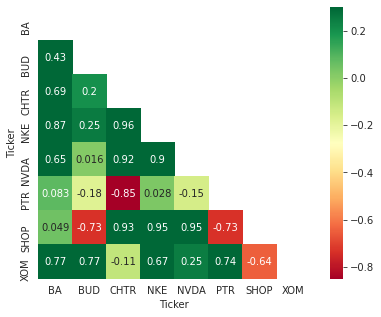

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

corr = df_pivot.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap='RdYlGn')


# 2. PyPortfolioOpt : min volatility, max Sharpe, and min cVAR portfolios
Three types of 'optimal' portfolios  

In [ ]:
# User guide: https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html
# https://github.com/robertmartin8/PyPortfolioOpt

!pip install PyPortfolioOpt

import pypfopt
print(f'\n Library version: {pypfopt.__version__}')

     |████████████████████████████████| 60 kB 2.8 MB/s 
     |████████████████████████████████| 2.7 MB 8.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31

 Library version: 1.4.2


In [ ]:
# https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb

from pypfopt import risk_models
from pypfopt import plotting

from pypfopt import expected_returns
from pypfopt import EfficientFrontier

Expected returns for each stock: Ticker
BA      0.213434
BUD     0.139353
CHTR    0.127584
NKE     0.197153
NVDA    0.393164
PTR     0.219011
SHOP    0.289967
XOM     0.129002
Name: mkt, dtype: float64 

Portfolio weights for min volatility optimisation (lowest level of risk): {
    "BA": 0.0,
    "BUD": 0.37202,
    "CHTR": 0.35686,
    "NKE": 0.03076,
    "NVDA": 0.0,
    "PTR": 0.04408,
    "SHOP": 0.14438,
    "XOM": 0.0519
} 

Expected annual return: 16.2%
Annual volatility: 8.9%
Sharpe Ratio: 1.67
Portfolio performance: (0.16165041366539995, 0.08897483692120163, 1.670139769932978) 

Portfolio weights for max Sharpe optimisation (highest return-per-risk): {
    "BA": 0.01337,
    "BUD": 0.23976,
    "CHTR": 0.15556,
    "NKE": 0.04143,
    "NVDA": 0.07875,
    "PTR": 0.11127,
    "SHOP": 0.35987,
    "XOM": 0.0
} 

Expected annual return: 22.4%
Annual volatility: 10.7%
Sharpe Ratio: 1.91
Portfolio performance: (0.22395840014926235, 0.10698305673708648, 1.906455156263624) 



/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:412: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


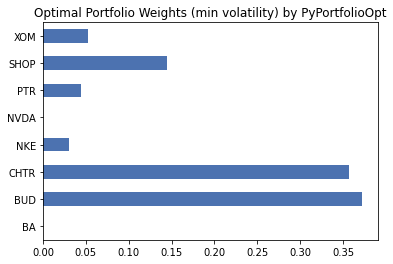

In [ ]:
# json: for pretty print of a dictionary: https://stackoverflow.com/questions/44689546/how-to-print-out-a-dictionary-nicely-in-python/44689627
import json

mu = expected_returns.capm_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.ema_historical_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.mean_historical_return(df_pivot.set_index('Date'))
print(f'Expected returns for each stock: {mu} \n')

S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()

# Weights between 0 and 1 - we don't allow shorting
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.min_volatility()
weights_min_volatility = ef.clean_weights()

print(f'Portfolio weights for min volatility optimisation (lowest level of risk): {json.dumps(weights_min_volatility, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.01305)} \n')
# Risk-free rate : 10Y TBonds rate on 21-Jul-2021 https://www.cnbc.com/quotes/US10Y

pd.Series(weights_min_volatility).plot.barh(title = 'Optimal Portfolio Weights (min volatility) by PyPortfolioOpt');

ef.max_sharpe()
weights_max_sharpe = ef.clean_weights()


print(f'Portfolio weights for max Sharpe optimisation (highest return-per-risk): {json.dumps(weights_max_sharpe, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.01305)} \n')


In [ ]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 22.4%
Annual volatility: 10.7%
Sharpe Ratio: 1.91


In [ ]:
returns = expected_returns.returns_from_prices(df_pivot.set_index('Date')).dropna()
returns.head()

Ticker,BA,BUD,CHTR,NKE,NVDA,PTR,SHOP,XOM
Date,,,,,,,,
2015-05-21,0.006352,0.004133,0.009607,-0.002007,-0.007130,-0.008265,0.510588,0.000918
2015-05-22,-0.017238,-0.011056,-0.018584,0.000287,-0.001436,0.019446,0.102414,-0.007912
2015-05-26,-0.013880,-0.020238,0.025381,-0.009671,-0.006232,-0.011381,0.047333,-0.013523
2015-05-27,0.001401,0.015659,-0.008510,-0.005608,0.053546,0.004297,-0.072513,-0.002812
2015-05-28,-0.004685,0.003608,-0.010603,-0.002535,0.013736,-0.031886,-0.001818,0.000000


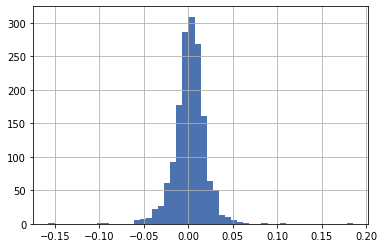

In [ ]:
# Compute CVaR
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

In [ ]:
# VaR
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -2.56%
CVaR: -4.01%


In [ ]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);

Expected annual return: 15.8%
Conditional Value at Risk: 2.99%


# 3. PyPortfolioOpt : Efficient Frontier
Building a convex efficient frontier, which explains the risk-return trade-off

In [ ]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True, risk_free_rate=0.01305);


Expected annual return: 21.6%
Annual volatility: 10.3%
Sharpe Ratio: 1.97


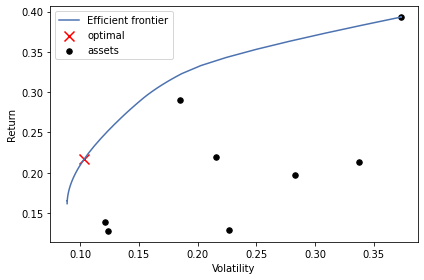

In [ ]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)


In [ ]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.22085296 0.21243112 0.15621343 ... 0.19618622 0.18209733 0.25292345]
Sample portfolio volatilities: 0       0.137026
1       0.133920
2       0.113982
3       0.151277
4       0.126129
          ...   
9995    0.176633
9996    0.160378
9997    0.183129
9998    0.133186
9999    0.178201
Length: 10000, dtype: float64


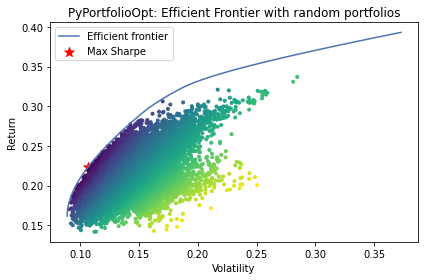

In [ ]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("PyPortfolioOpt: Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

# 4. PyPortfolioOpt : Discrete Allocation
Oftentimes, you don't have enough money to replicate the exact 'optimal' weights. So you need to find the closest possible portfolio with undivided amount of stocks 

In [ ]:
# last day prices
df_pivot.set_index('Date').iloc[-1]

Ticker
BA       212.750000
BUD       60.000000
CHTR     783.109985
NKE      165.716705
NVDA     197.789993
PTR       39.380001
SHOP    1469.859985
XOM       52.764999
Name: 2021-08-19, dtype: float64

In [ ]:
print(f'Portfolio weights for max Sharpe optimisation (highest return-per-risk): {json.dumps(weights_max_sharpe, indent=4, sort_keys=True)} \n')


Portfolio weights for max Sharpe optimisation (highest return-per-risk): {
    "BA": 0.01337,
    "BUD": 0.23976,
    "CHTR": 0.15556,
    "NKE": 0.04143,
    "NVDA": 0.07875,
    "PTR": 0.11127,
    "SHOP": 0.35987,
    "XOM": 0.0
} 



In [ ]:
df_last_day = stocks_prices[filter_last_date]
df_last_day['max_sharpe_weight']= df_last_day['Ticker'].apply(lambda x:weights_max_sharpe[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_last_day['stock_investment_amount'] = INVESTMENT*df_last_day['max_sharpe_weight'] /df_last_day['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_last_day[['Close','Ticker','Date','max_sharpe_weight','stock_investment_amount']]

,Close,Ticker,Date,max_sharpe_weight,stock_investment_amount
5376,39.380001,PTR,2021-08-19,0.11127,5.651092
8432,60.000000,BUD,2021-08-19,0.23976,7.992000
23442,52.764999,XOM,2021-08-19,0.00000,0.000000
38454,212.750000,BA,2021-08-19,0.01337,0.125687
41375,783.109985,CHTR,2021-08-19,0.15556,0.397288
42950,1469.859985,SHOP,2021-08-19,0.35987,0.489666
48633,197.789993,NVDA,2021-08-19,0.07875,0.796299
58898,165.716705,NKE,2021-08-19,0.04143,0.500010


In [ ]:
from pypfopt import DiscreteAllocation

latest_prices = df_pivot.set_index('Date').iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights_max_sharpe, latest_prices, total_portfolio_value = INVESTMENT, short_ratio=0.0)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation for the initial investment ${INVESTMENT} performed with ${leftover:.2f} leftover")
alloc

Discrete allocation for the initial investment $2000 performed with $137.10 leftover


{'BUD': 8, 'CHTR': 1, 'NKE': 1, 'NVDA': 1, 'PTR': 6}